# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
sessions_history = pd.read_csv('https://code.s3.yandex.net//datasets/sessions_project_history.csv') 
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [2]:
user_sessions_count = sessions_history.groupby('user_id')['session_id'].nunique()
max_sessions_user = user_sessions_count.idxmax()
user_data = sessions_history[sessions_history['user_id'] == max_sessions_user]
print(user_data)

                 user_id        session_id session_date     session_start_ts  \
115558  10E0DEFC1ABDBBE0  B8F0423BBFFCF5DC   2025-08-14  2025-08-14 13:57:39   
191751  10E0DEFC1ABDBBE0  87CA2FA549473837   2025-08-15  2025-08-15 16:42:10   
239370  10E0DEFC1ABDBBE0  4ADD8011DCDCE318   2025-08-16  2025-08-16 19:53:21   
274629  10E0DEFC1ABDBBE0  DF0FD0E09BF1F3D7   2025-08-17  2025-08-17 15:03:43   
302501  10E0DEFC1ABDBBE0  3C221774B4DE6885   2025-08-18  2025-08-18 17:29:14   
325557  10E0DEFC1ABDBBE0  031BD7A67048105B   2025-08-19  2025-08-19 13:23:55   
345336  10E0DEFC1ABDBBE0  FF4315CF4AD4B100   2025-08-20  2025-08-20 19:31:54   
377532  10E0DEFC1ABDBBE0  4045FEA0747203B4   2025-08-22  2025-08-22 17:54:13   
403538  10E0DEFC1ABDBBE0  344B086C421C7F37   2025-08-24  2025-08-24 14:46:13   
414743  10E0DEFC1ABDBBE0  054F20BA371E4C9D   2025-08-25  2025-08-25 18:36:41   

       install_date  session_number  registration_flag  page_counter region  \
115558   2025-08-14               1     

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

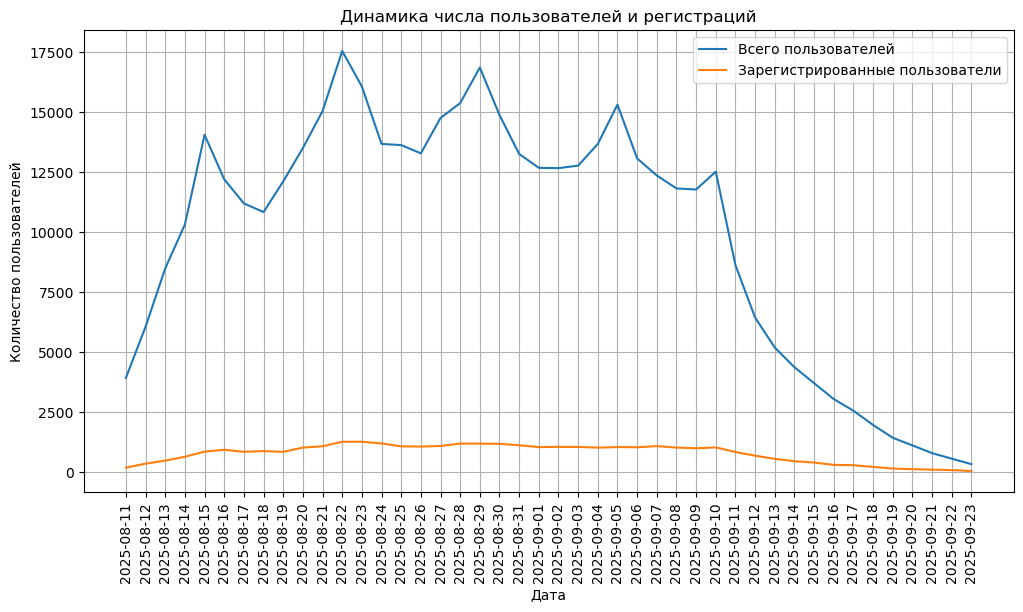

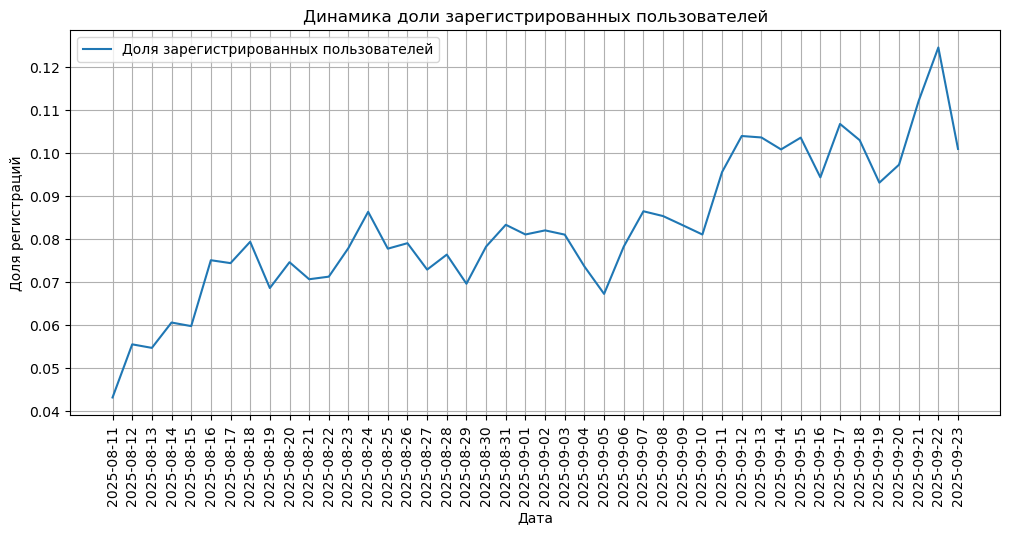

In [3]:
registrations_by_date = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')
).reset_index()

registrations_by_date['registration_rate'] = registrations_by_date['registered_users'] / registrations_by_date['total_users']
plt.figure(figsize=(12, 6))
plt.plot(registrations_by_date['session_date'], registrations_by_date['total_users'], label='Всего пользователей')
plt.plot(registrations_by_date['session_date'], registrations_by_date['registered_users'], label='Зарегистрированные пользователи')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Динамика числа пользователей и регистраций')
plt.legend()
plt.xticks(rotation = 90)
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(registrations_by_date['session_date'], registrations_by_date['registration_rate'], label='Доля зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля регистраций')
plt.title('Динамика доли зарегистрированных пользователей')
plt.legend()
plt.xticks(rotation = 90)
plt.grid()
plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

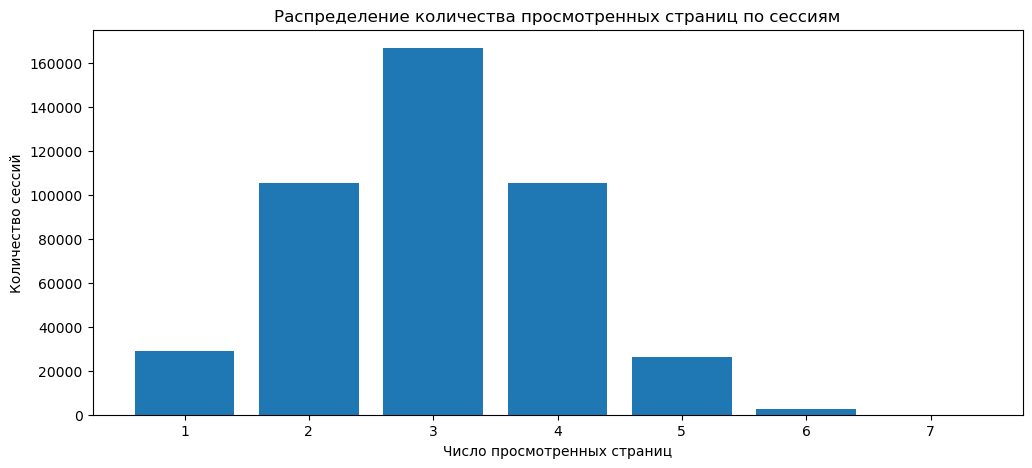

In [4]:
page_views_count = sessions_history.groupby('page_counter')['session_id'].count().reset_index()

plt.figure(figsize=(12, 5))
plt.bar(page_views_count['page_counter'], page_views_count['session_id'])
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.title('Распределение количества просмотренных страниц по сессиям')
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

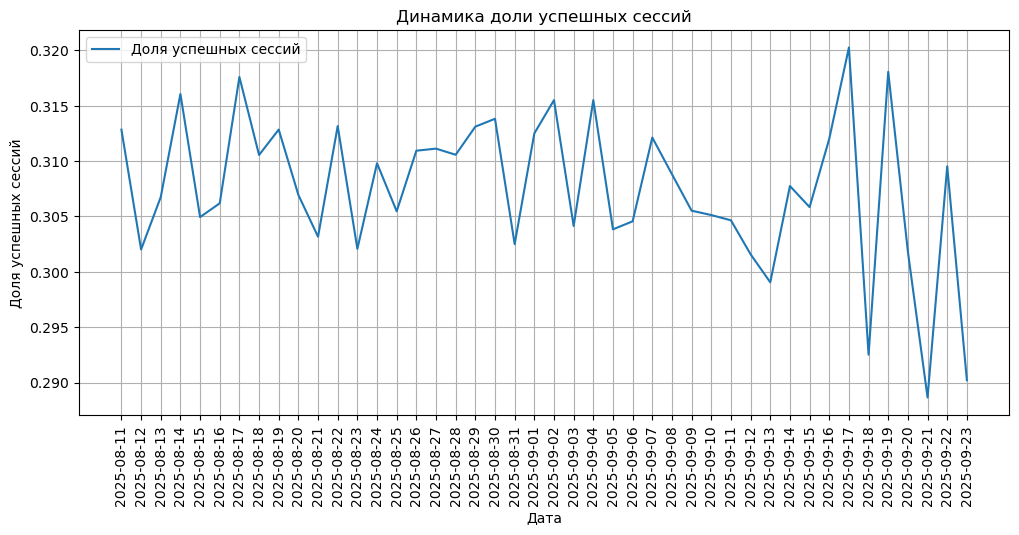

In [5]:
def mark_good_session(page_count):
    return 1 if page_count >= 4 else 0

sessions_history['good_session'] = sessions_history['page_counter'].apply(mark_good_session)
successful_sessions_by_date = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(successful_sessions_by_date['session_date'], successful_sessions_by_date['good_session'], label='Доля успешных сессий')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.title('Динамика доли успешных сессий')
plt.legend()
plt.grid()
plt.xticks(rotation = 90)
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [6]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [7]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

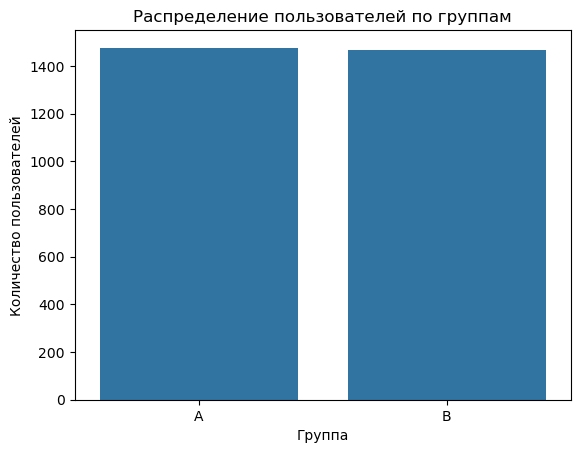

Количество пользователей: A = 1477, B = 1466
Процентная разница: 0.74%


In [8]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net//datasets/sessions_project_test_part.csv') 
user_counts = sessions_test_part.groupby('test_group')['user_id'].nunique()
percent_diff = 100 * abs(user_counts['A'] - user_counts['B']) / user_counts['A']
sns.barplot(x=user_counts.index, y=user_counts.values)
plt.xlabel("Группа")
plt.ylabel("Количество пользователей")
plt.title("Распределение пользователей по группам")
plt.show()
print(f"Количество пользователей: A = {user_counts['A']}, B = {user_counts['B']}")
print(f"Процентная разница: {percent_diff:.2f}%")

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [9]:
users_in_both = sessions_test_part.groupby('user_id')['test_group'].nunique()
overlapping_users = (users_in_both > 1).sum()
print(f"Число пользователей в обеих группах: {overlapping_users}")

Число пользователей в обеих группах: 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


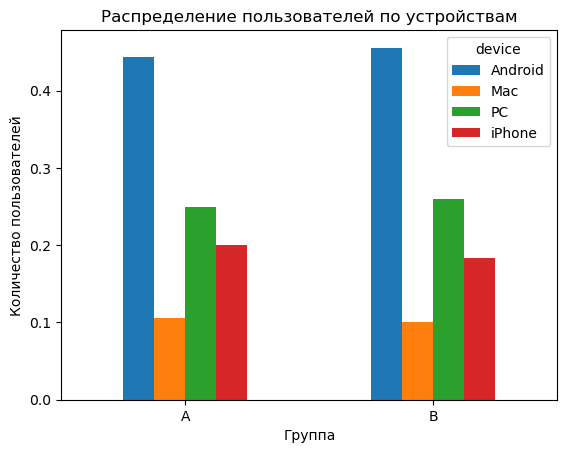

device,Android,Mac,PC,iPhone
test_group,,,,
A,0.444144,0.105619,0.249831,0.200406
B,0.455662,0.100955,0.259891,0.183492


In [10]:
device_counts = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().unstack()
device_counts = device_counts.div(device_counts.sum(axis=1), axis=0)
device_counts.plot(kind='bar')
plt.title("Распределение пользователей по устройствам")
plt.xlabel("Группа")
plt.ylabel("Количество пользователей")
plt.xticks(rotation=0)
plt.show()
display(device_counts)

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


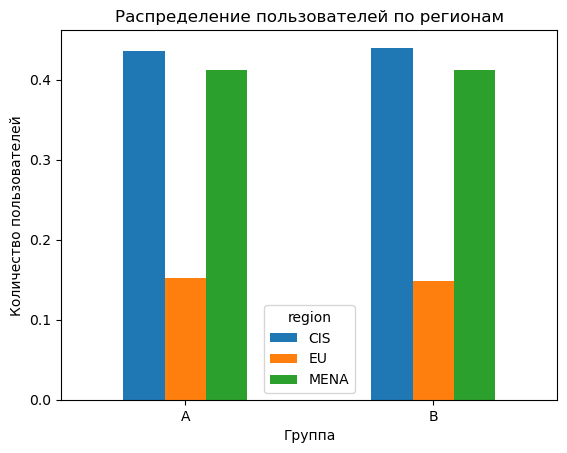

region,CIS,EU,MENA
test_group,,,
A,0.436019,0.151659,0.412322
B,0.439973,0.148022,0.412005


In [11]:
region_counts = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().unstack()
region_counts = region_counts.div(region_counts.sum(axis=1), axis=0)
region_counts.plot(kind='bar')
plt.title("Распределение пользователей по регионам")
plt.xlabel("Группа")
plt.ylabel("Количество пользователей")
plt.xticks(rotation=0)
plt.show()
display(region_counts)

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

***Распределение пользователей между группами корректное, разница в количестве менее 1%. Выборки независимы, так как отсутствуют пересечения пользователей. Распределение по устройствам и регионам равномерное, значительных перекосов нет. A/B-тест проходит корректно, и можно переходить к анализу ключевых метрик.***

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [12]:
def mark_good_session(page_count):
    return 1 if page_count >= 4 else 0

sessions_test = pd.read_csv('https://code.s3.yandex.net//datasets/sessions_project_test.csv') 
sessions_test['good_session'] = sessions_test['page_counter'].apply(mark_good_session)
sessions_test_by_date = sessions_test.groupby('session_date')['good_session'].mean().reset_index()

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [13]:
user_counts = sessions_test.groupby('test_group')['session_id'].nunique()
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack()
t_stat, p_value_sessions = ttest_ind(daily_sessions['A'].dropna(), daily_sessions['B'].dropna(), equal_var=False)
print(f"p-value для количества сессий: {p_value_sessions:.4f}")
if p_value_sessions < 0.05:
    print("Количество сессий статистически различается.")
else:
    print("Количество сессий не имеет статистически значимых различий.")

p-value для количества сессий: 0.9382
Количество сессий не имеет статистически значимых различий.


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [14]:
success_rates = sessions_test.groupby('test_group')['good_session'].mean()
diff = success_rates['B'] - success_rates['A']

print(f"Доля успешных сессий: A = {success_rates['A']:.4f}, B = {success_rates['B']:.4f}")
print(f"Разница в успешных сессиях: {diff:.4f}")

Доля успешных сессий: A = 0.3077, B = 0.3183
Разница в успешных сессиях: 0.0106


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 0.5% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [15]:
count = sessions_test.groupby('test_group')['good_session'].sum()
nobs = sessions_test.groupby('test_group')['good_session'].count()
z_stat, p_value = proportions_ztest(count, nobs)
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Различие статистически значимо.")
else:
    print("Нет статистически значимого различия.")

p-value: 0.0003
Различие статистически значимо.


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

***В эксперименте приняли участие 34,882 пользователей (по 17,441 в каждой группе), и он длился 4 дня. 
Внедрение нового алгоритма рекомендаций не привело к статистически значимому улучшению ключевой метрики (доля успешных сессий). Разница в доле успешных сессий между группами A и B была маленькой и не была значительной. 
Для оценки значимости изменений был рассчитан p-value, который составил 0.0003. Если p-value < 0.05, разница считается статистически значимой.  
На основании результатов теста стоит внедрять новый алгоритм в приложение.***

